## 1. Import Required Libraries

In [1]:
import os
import glob
import re
from pathlib import Path
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
import skimage

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Define Dataset Paths

In [2]:
# Dataset paths
DATASET1_PATH = "/data/common/STEREOSTUDYIPSL/Datasets/gQg5IUvV/srf02_0a_skyimgLz2_v01_20250406_044600_853/20250406"
DATASET2_PATH = "/data/common/STEREOSTUDYIPSL/Datasets/OdnkTZQ8/RAW/RAW"

print(f"Dataset 1: {DATASET1_PATH}")
print(f"Dataset 2: {DATASET2_PATH}")
print(f"\nDataset 1 exists: {os.path.exists(DATASET1_PATH)}")
print(f"Dataset 2 exists: {os.path.exists(DATASET2_PATH)}")

Dataset 1: /data/common/STEREOSTUDYIPSL/Datasets/gQg5IUvV/srf02_0a_skyimgLz2_v01_20250406_044600_853/20250406
Dataset 2: /data/common/STEREOSTUDYIPSL/Datasets/OdnkTZQ8/RAW/RAW

Dataset 1 exists: True
Dataset 2 exists: True


## 3. File Discovery Functions

In [3]:
def find_dataset1_images(base_path: str) -> List[str]:
    """
    Find all images ending in _01.jpg from Dataset 1.
    
    Args:
        base_path: Path to the dataset directory
        
    Returns:
        Sorted list of image file paths
    """
    pattern = os.path.join(base_path, "*_01.jpg")
    images = sorted(glob.glob(pattern))
    print(f"Found {len(images)} images ending in '_01.jpg'")
    return images


def find_dataset2_images(base_path: str) -> List[str]:
    """
    Find all JP2 images with even minute timestamps from Dataset 2.
    
    Args:
        base_path: Path to the dataset directory
        
    Returns:
        Sorted list of image file paths with even minutes
    """
    pattern = os.path.join(base_path, "image_*.jp2")
    all_images = glob.glob(pattern)
    
    # Filter for even minute timestamps
    # Format: image_YYYYMMDDHHMMSS.jp2
    # Extract minutes (positions 10-12 in the timestamp)
    even_minute_images = []
    
    for img_path in all_images:
        filename = os.path.basename(img_path)
        # Extract timestamp from filename
        match = re.search(r'image_(\d{14})\.jp2', filename)
        if match:
            timestamp = match.group(1)
            # Extract minutes (characters 10-12 in YYYYMMDDHHMMSS)
            minutes = int(timestamp[10:12])
            # Check if even minute
            if minutes % 2 == 0:
                even_minute_images.append(img_path)
    
    even_minute_images.sort()
    print(f"Found {len(even_minute_images)} images with even minute timestamps (out of {len(all_images)} total)")
    return even_minute_images


def extract_timestamp_from_path(filepath: str, dataset_type: int) -> datetime:
    """
    Extract datetime from filename.
    
    Args:
        filepath: Path to the image file
        dataset_type: 1 for Dataset1, 2 for Dataset2
        
    Returns:
        datetime object
    """
    filename = os.path.basename(filepath)
    
    if dataset_type == 1:
        # Format: YYYYMMDDHHMMSS_01.jpg
        match = re.search(r'(\d{14})_\d+\.jpg', filename)
        if match:
            timestamp_str = match.group(1)
            return datetime.strptime(timestamp_str, "%Y%m%d%H%M%S")
    elif dataset_type == 2:
        # Format: image_YYYYMMDDHHMMSS.jp2
        match = re.search(r'image_(\d{14})\.jp2', filename)
        if match:
            timestamp_str = match.group(1)
            return datetime.strptime(timestamp_str, "%Y%m%d%H%M%S")
    
    return None

In [12]:
# Prepare our ground camera

def increase_brightness(image: np.ndarray, alpha: float = 1.0, beta: int = 50) -> np.ndarray:
    """
    Augments the brightness of an image by adjusting its contrast and brightness.

    Parameters:
    - image: The input image on which brightness and contrast adjustments are to be made.
    - alpha: The contrast factor. A value of 1.0 means no change, less than 1.0 decreases contrast, and more than 1.0 increases contrast.
    - beta: The brightness adjustment value. Positive values make the image brighter, and negative values make it darker.

    Returns:
    - An image with adjusted brightness and contrast.
    """
    # Adjust the image's contrast and brightness, returning the modified image
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta) 
    return adjusted_image


def increase_contrast(image: np.ndarray, clip_limit: float = 3.0, tile_grid_size: Tuple[int, int] = (8, 8)) -> np.ndarray:
    """
    Increases the contrast of an image using the CLAHE algorithm.

    Parameters:
    - image (np.ndarray): The input image in BGR format.
    - clip_limit (float, optional): Threshold for contrast limiting. Default is 3.0.
    - tile_grid_size (Tuple[int, int], optional): Size of the grid for the histogram equalization. The default tile grid size is (8, 8).

    Returns:
    - np.ndarray: The image with increased contrast in BGR format.
    """
    # Convert the input image from BGR to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    
    # Split the LAB image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    
    # Create a CLAHE object with specified clip limit and tile grid size
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # Apply CLAHE on the L-channel
    enhanced_l_channel = clahe.apply(l_channel)
    
    # Merge the enhanced L-channel with the original A and B channels
    merged_channels = cv2.merge([enhanced_l_channel, a_channel, b_channel])
    
    # Convert the merged channels back from LAB to BGR color space
    contrast_enhanced_image = cv2.cvtColor(merged_channels, cv2.COLOR_Lab2BGR)
    return contrast_enhanced_image


def decrease_warmth(image: np.ndarray, adjustment_value: int = 50) -> np.ndarray:
    """
    Decreases the warmth of an image by adjusting the blue and red channels.

    Parameters:
    - image (np.ndarray): The input image in BGR format.
    - adjustment_value (int, optional): The value to adjust the blue and red channels by. Default is 50.

    Returns:
    - np.ndarray: The image with decreased warmth in BGR format.
    """
    # Split the input image into its Blue, Green, and Red channels
    blue_channel, green_channel, red_channel = cv2.split(image)

    # Decrease the blue channel's intensity to reduce warmth
    blue_channel = cv2.subtract(blue_channel, adjustment_value)  
    
    # Increase the red channel's intensity to compensate and maintain color balance
    red_channel = cv2.add(red_channel, adjustment_value) 
    
    # Clip the blue channel values to ensure they remain within [0, 255]
    blue_channel = np.clip(blue_channel, 0, 255)
    
    # Clip the red channel values to ensure they remain within [0, 255]
    red_channel = np.clip(red_channel, 0, 255)
    
    # Merge the adjusted channels back into a single image
    cooler_image = cv2.merge([blue_channel, green_channel, red_channel])
    return cooler_image


def enhance_image(image: np.ndarray) -> np.ndarray:
    """
    Enhances an image by applying a sequence of operations: increasing brightness, increasing contrast, and decreasing warmth.

    Parameters:
    - image (np.ndarray): The input image in BGR format.

    Returns:
    - np.ndarray: The enhanced image in BGR format.
    """
    # Increase the brightness of the image
    brighter_image = increase_brightness(image)
    
    # Increase the contrast of the brighter image
    more_contrasted_image = increase_contrast(brighter_image)
    
    # Decrease the warmth of the more contrasted image to finalize the enhancement
    enhanced_image = decrease_warmth(more_contrasted_image)

    # Display the final enhanced image
    random_number = np.random.randint(0, 10000)
    if random_number % 10 == 0:  # Display approximately 0.1% of images
        plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    return enhanced_image


def process_one_file(src_file, dst_file):
    if os.path.exists(dst_file):
        # Fichier déjà traité, on skip
        return
    try:
        image_array = skimage.io.imread(src_file)
        # projected_image = camera_projector.project_image(image_array)
        enhanced_image = enhance_image(image_array)

        fig, ax = plt.subplots(figsize=(10.24, 10.24), dpi=100)
        ax.imshow(enhanced_image)
        ax.axis('off')
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.savefig(dst_file, dpi=100, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
    except:
        return

## 4. Discover Images from Both Datasets

In [13]:
# Discover images in parallel
print("Discovering images from both datasets...\n")

with ThreadPoolExecutor(max_workers=2) as executor:
    future_dataset1 = executor.submit(find_dataset1_images, DATASET1_PATH)
    future_dataset2 = executor.submit(find_dataset2_images, DATASET2_PATH)
    
    dataset1_images = future_dataset1.result()
    dataset2_images = future_dataset2.result()

print(f"\n{'='*60}")
print(f"Dataset 1: {len(dataset1_images)} images")
print(f"Dataset 2: {len(dataset2_images)} images")
print(f"{'='*60}")

Discovering images from both datasets...

Found 427 images ending in '_01.jpg'
Found 721 images with even minute timestamps (out of 1441 total)

Dataset 1: 427 images
Dataset 2: 721 images


## 5. Display Sample Filenames

In [14]:
# Show first 10 images from each dataset
print("Sample images from Dataset 1 (_01.jpg):")
for img in dataset1_images[:10]:
    print(f"  {os.path.basename(img)}")

print("\nSample images from Dataset 2 (even minutes):")
for img in dataset2_images[:10]:
    print(f"  {os.path.basename(img)}")

Sample images from Dataset 1 (_01.jpg):
  20250406044600_01.jpg
  20250406044800_01.jpg
  20250406045000_01.jpg
  20250406045200_01.jpg
  20250406045400_01.jpg
  20250406045600_01.jpg
  20250406045800_01.jpg
  20250406050000_01.jpg
  20250406050200_01.jpg
  20250406050400_01.jpg

Sample images from Dataset 2 (even minutes):
  image_20250406050000.jp2
  image_20250406050030.jp2
  image_20250406050200.jp2
  image_20250406050230.jp2
  image_20250406050400.jp2
  image_20250406050430.jp2
  image_20250406050600.jp2
  image_20250406050630.jp2
  image_20250406050800.jp2
  image_20250406050830.jp2


## 6. Create Timestamp Index for Both Datasets

In [15]:
# Create dictionaries mapping timestamps to file paths
print("Creating timestamp indices...")

dataset1_index = {}
for img_path in tqdm(dataset1_images, desc="Indexing Dataset 1"):
    timestamp = extract_timestamp_from_path(img_path, 1)
    if timestamp:
        dataset1_index[timestamp] = img_path

dataset2_index = {}
for img_path in tqdm(dataset2_images, desc="Indexing Dataset 2"):
    timestamp = extract_timestamp_from_path(img_path, 2)
    if timestamp:
        dataset2_index[timestamp] = img_path

print(f"\nDataset 1 indexed: {len(dataset1_index)} timestamps")
print(f"Dataset 2 indexed: {len(dataset2_index)} timestamps")

Creating timestamp indices...


Indexing Dataset 2: 100%|██████████| 721/721 [00:00<00:00, 125481.04it/s]


Dataset 1 indexed: 427 timestamps
Dataset 2 indexed: 721 timestamps


## 7. Find Matching Timestamps

In [16]:
# Find timestamps that exist in both datasets
common_timestamps = sorted(set(dataset1_index.keys()) & set(dataset2_index.keys()))

print(f"Found {len(common_timestamps)} matching timestamps between both datasets")

if len(common_timestamps) > 0:
    print(f"\nTime range:")
    print(f"  Start: {common_timestamps[0]}")
    print(f"  End:   {common_timestamps[-1]}")
    print(f"\nFirst 5 matching timestamps:")
    for ts in common_timestamps[:5]:
        print(f"  {ts}")
else:
    print("\nNo exact timestamp matches found.")
    print("Dataset 1 time range:", min(dataset1_index.keys()), "to", max(dataset1_index.keys()))
    print("Dataset 2 time range:", min(dataset2_index.keys()), "to", max(dataset2_index.keys()))

Found 361 matching timestamps between both datasets

Time range:
  Start: 2025-04-06 05:00:00
  End:   2025-04-06 17:00:00

First 5 matching timestamps:
  2025-04-06 05:00:00
  2025-04-06 05:02:00
  2025-04-06 05:04:00
  2025-04-06 05:06:00
  2025-04-06 05:08:00


## 8. Parallel Image Loading Function

In [ ]:
def load_image_pair(timestamp: datetime, dataset1_index: Dict, dataset2_index: Dict, 
                    apply_histogram_matching: bool = False, reference_img: np.ndarray = None) -> Tuple:
    """
    Load a pair of images for a given timestamp.
    
    Args:
        timestamp: Datetime to load images for
        dataset1_index: Index of Dataset 1 images
        dataset2_index: Index of Dataset 2 images
        apply_histogram_matching: Whether to apply histogram matching to Dataset 2
        reference_img: Reference image for histogram matching (Dataset 1 reference)
        
    Returns:
        Tuple of (timestamp, img1, img2, path1, path2)
    """
    try:
        path1 = dataset1_index[timestamp]
        path2 = dataset2_index[timestamp]
        
        # Load images
        img1 = Image.open(path1)
        img2 = Image.open(path2)

        # Convert to RGB if necessary
        if img1.mode != 'RGB':
            img1 = img1.convert('RGB')
        if img2.mode != 'RGB':
            img2 = img2.convert('RGB')
        
        # Apply enhancement to Dataset 2 image (JP2)
        img2_array = np.array(img2)
        # Convert RGB to BGR for OpenCV processing
        img2_bgr = cv2.cvtColor(img2_array, cv2.COLOR_RGB2BGR)
        enhanced_img2 = enhance_image(img2_bgr)
        # Convert back to RGB for PIL
        enhanced_img2_rgb = cv2.cvtColor(enhanced_img2, cv2.COLOR_BGR2RGB)
        
        # Apply histogram matching if enabled
        if apply_histogram_matching and reference_img is not None:
            enhanced_img2_rgb = match_histogram(enhanced_img2_rgb, reference_img)
        
        img2 = Image.fromarray(enhanced_img2_rgb)
        
        return (timestamp, img1, img2, path1, path2)
    except Exception as e:
        print(f"Error loading images for {timestamp}: {e}")
        return None


def load_image_pairs_parallel(timestamps: List[datetime], dataset1_index: Dict, 
                              dataset2_index: Dict, max_pairs: int = None,
                              apply_histogram_matching: bool = False,
                              reference_img: np.ndarray = None) -> List[Tuple]:
    """
    Load multiple image pairs in parallel.
    
    Args:
        timestamps: List of timestamps to load
        dataset1_index: Index of Dataset 1 images
        dataset2_index: Index of Dataset 2 images
        max_pairs: Maximum number of pairs to load (None for all)
        apply_histogram_matching: Whether to apply histogram matching to Dataset 2
        reference_img: Reference image for histogram matching
        
    Returns:
        List of loaded image pairs
    """
    if max_pairs:
        timestamps = timestamps[:max_pairs]
    
    pairs = []
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(load_image_pair, ts, dataset1_index, dataset2_index,
                                  apply_histogram_matching, reference_img) 
                   for ts in timestamps]
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading image pairs"):
            result = future.result()
            if result:
                pairs.append(result)
    
    # Sort by timestamp
    pairs.sort(key=lambda x: x[0])
    return pairs    

print("✓ Image loading functions defined")

✓ Image loading functions defined


## 9. Load Sample Image Pairs

Loading 10 sample image pairs...


Loading image pairs:  90%|█████████ | 9/10 [00:01<00:00,  7.46it/s]

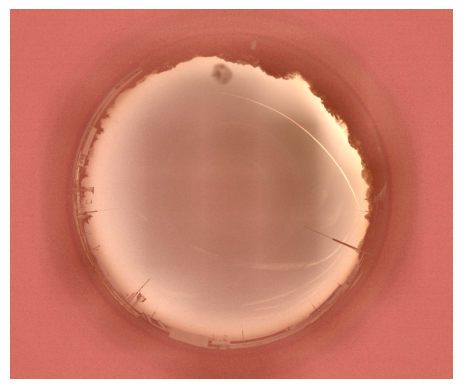

Loading image pairs: 100%|██████████| 10/10 [00:01<00:00,  5.67it/s]

✓ Loaded 10 image pairs successfully


In [ ]:
# Load first 10 matching pairs (or adjust as needed)
NUM_SAMPLES = min(10, len(common_timestamps))

if NUM_SAMPLES > 0:
    print(f"Loading {NUM_SAMPLES} sample image pairs...")
    
    # Check if we should apply histogram matching
    apply_matching = 'reference_image_dataset1' in globals() and reference_image_dataset1 is not None
    reference = reference_image_dataset1 if apply_matching else None
    
    if apply_matching:
        print("✓ Histogram matching will be applied to Dataset 2")
    
    sample_pairs = load_image_pairs_parallel(
        common_timestamps, dataset1_index, dataset2_index, 
        max_pairs=NUM_SAMPLES,
        apply_histogram_matching=apply_matching,
        reference_img=reference
    )
    print(f"✓ Loaded {len(sample_pairs)} image pairs successfully")
else:
    sample_pairs = []
    print("No matching timestamps to load")

## 10. Visualize Image Pairs Side-by-Side

## 10d. Compare Results: With vs Without Histogram Matching

In [ ]:
# Load a few pairs to compare with and without histogram matching
if len(common_timestamps) > 0 and 'reference_image_dataset1' in globals():
    print("Loading sample pairs for comparison...")
    
    # Load without histogram matching
    print("\n1. Loading WITHOUT histogram matching:")
    pairs_no_matching = load_image_pairs_parallel(
        common_timestamps[:3], dataset1_index, dataset2_index,
        apply_histogram_matching=False
    )
    
    # Load with histogram matching
    print("\n2. Loading WITH histogram matching:")
    pairs_with_matching = load_image_pairs_parallel(
        common_timestamps[:3], dataset1_index, dataset2_index,
        apply_histogram_matching=True,
        reference_img=reference_image_dataset1
    )
    
    # Visualize comparison
    if pairs_no_matching and pairs_with_matching:
        print("\n" + "="*70)
        print("COMPARISON: Dataset 2 WITHOUT Histogram Matching")
        print("="*70)
        visualize_image_pairs(pairs_no_matching, num_rows=3)
        
        print("\n" + "="*70)
        print("COMPARISON: Dataset 2 WITH Histogram Matching")
        print("="*70)
        visualize_image_pairs(pairs_with_matching, num_rows=3)
        
        print("\n✓ Notice how the color palettes are now more aligned after histogram matching!")
else:
    print("Skipping comparison - not enough data or reference histogram not computed")

In [19]:
def visualize_image_pairs(pairs: List[Tuple], num_rows: int = 5, figsize: Tuple = (16, 4)):
    """
    Visualize image pairs side-by-side.
    
    Args:
        pairs: List of image pairs (timestamp, img1, img2, path1, path2)
        num_rows: Number of rows to display
        figsize: Figure size per row
    """
    if not pairs:
        print("No image pairs to visualize")
        return
    
    num_pairs = min(num_rows, len(pairs))
    
    fig, axes = plt.subplots(num_pairs, 2, figsize=(figsize[0], figsize[1] * num_pairs))
    
    # Handle single row case
    if num_pairs == 1:
        axes = [axes]
    
    for idx, (timestamp, img1, img2, path1, path2) in enumerate(pairs[:num_pairs]):
        # Display Dataset 1 image
        axes[idx][0].imshow(img1)
        axes[idx][0].set_title(f"Dataset 1 (_01.jpg)\n{timestamp.strftime('%Y-%m-%d %H:%M:%S')}", 
                               fontsize=10, fontweight='bold')
        axes[idx][0].axis('off')
        
        # Display Dataset 2 image
        axes[idx][1].imshow(img2)
        axes[idx][1].set_title(f"Dataset 2 (even min .jp2)\n{timestamp.strftime('%Y-%m-%d %H:%M:%S')}", 
                               fontsize=10, fontweight='bold')
        axes[idx][1].axis('off')
    
    plt.tight_layout()
    plt.show()


# Visualize the loaded pairs
if sample_pairs:
    print(f"Displaying {min(5, len(sample_pairs))} image pairs:")
    visualize_image_pairs(sample_pairs, num_rows=5)
else:
    print("No image pairs available for visualization")

Displaying 5 image pairs:


In [22]:
# Histogram Matching Implementation

from skimage import exposure

def compute_color_histogram(image_paths: List[str], num_samples: int = 50) -> np.ndarray:
    """
    Compute average color histogram from a sample of images.
    
    Args:
        image_paths: List of image file paths
        num_samples: Number of images to sample for histogram computation
        
    Returns:
        Representative image for histogram matching (averaged)
    """
    samples = min(num_samples, len(image_paths))
    sampled_paths = np.random.choice(image_paths, samples, replace=False)
    
    all_images = []
    print(f"Computing color histogram from {samples} sample images...")
    
    for path in tqdm(sampled_paths, desc="Loading samples"):
        try:
            img = Image.open(path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            all_images.append(np.array(img))
        except Exception as e:
            print(f"Error loading {path}: {e}")
            continue
    
    if not all_images:
        return None
    
    # Compute mean image as reference
    mean_image = np.mean(all_images, axis=0).astype(np.uint8)
    return mean_image


def match_histogram(source_image: np.ndarray, reference_image: np.ndarray) -> np.ndarray:
    """
    Match the histogram of source image to reference image.
    
    Args:
        source_image: Image to transform (RGB)
        reference_image: Reference image with target histogram (RGB)
        
    Returns:
        Histogram-matched image
    """
    # Apply histogram matching per channel
    matched = exposure.match_histograms(source_image, reference_image, channel_axis=2)
    return matched.astype(np.uint8)


def visualize_histograms(img1: np.ndarray, img2: np.ndarray, img2_matched: np.ndarray = None):
    """
    Visualize color histograms for comparison.
    
    Args:
        img1: Dataset 1 image (reference)
        img2: Dataset 2 original image
        img2_matched: Dataset 2 image after histogram matching (optional)
    """
    colors = ['red', 'green', 'blue']
    labels = ['Red', 'Green', 'Blue']
    
    num_plots = 3 if img2_matched is not None else 2
    fig, axes = plt.subplots(2, num_plots, figsize=(6*num_plots, 8))
    
    # Show images
    axes[0, 0].imshow(img1)
    axes[0, 0].set_title('Dataset 1 (Reference)', fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img2)
    axes[0, 1].set_title('Dataset 2 (Original)', fontweight='bold')
    axes[0, 1].axis('off')
    
    if img2_matched is not None:
        axes[0, 2].imshow(img2_matched)
        axes[0, 2].set_title('Dataset 2 (Matched)', fontweight='bold')
        axes[0, 2].axis('off')
    
    # Plot histograms
    for i, (color, label) in enumerate(zip(colors, labels)):
        # Dataset 1 histogram
        hist1, bins1 = np.histogram(img1[:,:,i].flatten(), bins=256, range=(0, 256))
        axes[1, 0].plot(bins1[:-1], hist1, color=color, alpha=0.7, label=label)
        
        # Dataset 2 original histogram
        hist2, bins2 = np.histogram(img2[:,:,i].flatten(), bins=256, range=(0, 256))
        axes[1, 1].plot(bins2[:-1], hist2, color=color, alpha=0.7, label=label)
        
        # Dataset 2 matched histogram
        if img2_matched is not None:
            hist3, bins3 = np.histogram(img2_matched[:,:,i].flatten(), bins=256, range=(0, 256))
            axes[1, 2].plot(bins3[:-1], hist3, color=color, alpha=0.7, label=label)
    
    axes[1, 0].set_title('Dataset 1 Histogram')
    axes[1, 0].set_xlabel('Pixel Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    axes[1, 1].set_title('Dataset 2 Original Histogram')
    axes[1, 1].set_xlabel('Pixel Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    if img2_matched is not None:
        axes[1, 2].set_title('Dataset 2 Matched Histogram')
        axes[1, 2].set_xlabel('Pixel Value')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].legend()
        axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Histogram matching functions defined")

✓ Histogram matching functions defined


## Histogram Matching for Color Palette Alignment

This section implements histogram matching to align the color distributions between Dataset 1 and Dataset 2.

**Process:**
1. **Compute Reference Histograms**: Sample 50 images from each dataset to compute representative color distributions
2. **Visualize Distributions**: Compare the original color histograms (RGB channels) between datasets
3. **Apply Transformation**: Use scikit-image's `exposure.match_histograms()` to map Dataset 2 colors to Dataset 1's distribution
4. **Validation**: Compare before/after results to verify color palette alignment

**Benefits:**
- Ensures consistent color appearance across both datasets
- Maintains relative contrast and detail while adjusting color distribution
- Applied per-channel (R, G, B) for accurate color mapping

## 10a. Compute Reference Histograms from Both Datasets

In [23]:
# Compute representative histograms from both datasets
print("Computing reference color distributions from both datasets...\n")

# Set random seed for reproducibility
np.random.seed(42)

# Compute reference images for histogram matching
print("Dataset 1 (Reference):")
reference_image_dataset1 = compute_color_histogram(dataset1_images, num_samples=50)

print("\nDataset 2 (To be matched):")
reference_image_dataset2 = compute_color_histogram(dataset2_images, num_samples=50)

if reference_image_dataset1 is not None and reference_image_dataset2 is not None:
    print("\n✓ Reference histograms computed successfully")
    print(f"Reference image shapes: Dataset1={reference_image_dataset1.shape}, Dataset2={reference_image_dataset2.shape}")
else:
    print("\n✗ Failed to compute reference histograms")

Computing reference color distributions from both datasets...

Dataset 1 (Reference):
Computing color histogram from 50 sample images...


Computing reference color distributions from both datasets...

Dataset 1 (Reference):
Computing color histogram from 50 sample images...


Loading samples: 100%|██████████| 50/50 [00:00<00:00, 55.51it/s]



Computing reference color distributions from both datasets...

Dataset 1 (Reference):
Computing color histogram from 50 sample images...


Loading samples: 100%|██████████| 50/50 [00:00<00:00, 55.51it/s]




Dataset 2 (To be matched):
Computing color histogram from 50 sample images...


Loading samples: 100%|██████████| 50/50 [00:03<00:00, 12.56it/s]



Computing reference color distributions from both datasets...

Dataset 1 (Reference):
Computing color histogram from 50 sample images...


Loading samples: 100%|██████████| 50/50 [00:00<00:00, 55.51it/s]




Dataset 2 (To be matched):
Computing color histogram from 50 sample images...


Loading samples: 100%|██████████| 50/50 [00:03<00:00, 12.56it/s]




✓ Reference histograms computed successfully
Reference image shapes: Dataset1=(768, 1024, 3), Dataset2=(2056, 2464, 3)


## 10b. Visualize Original Color Distributions

Comparing original color distributions:


Comparing original color distributions:


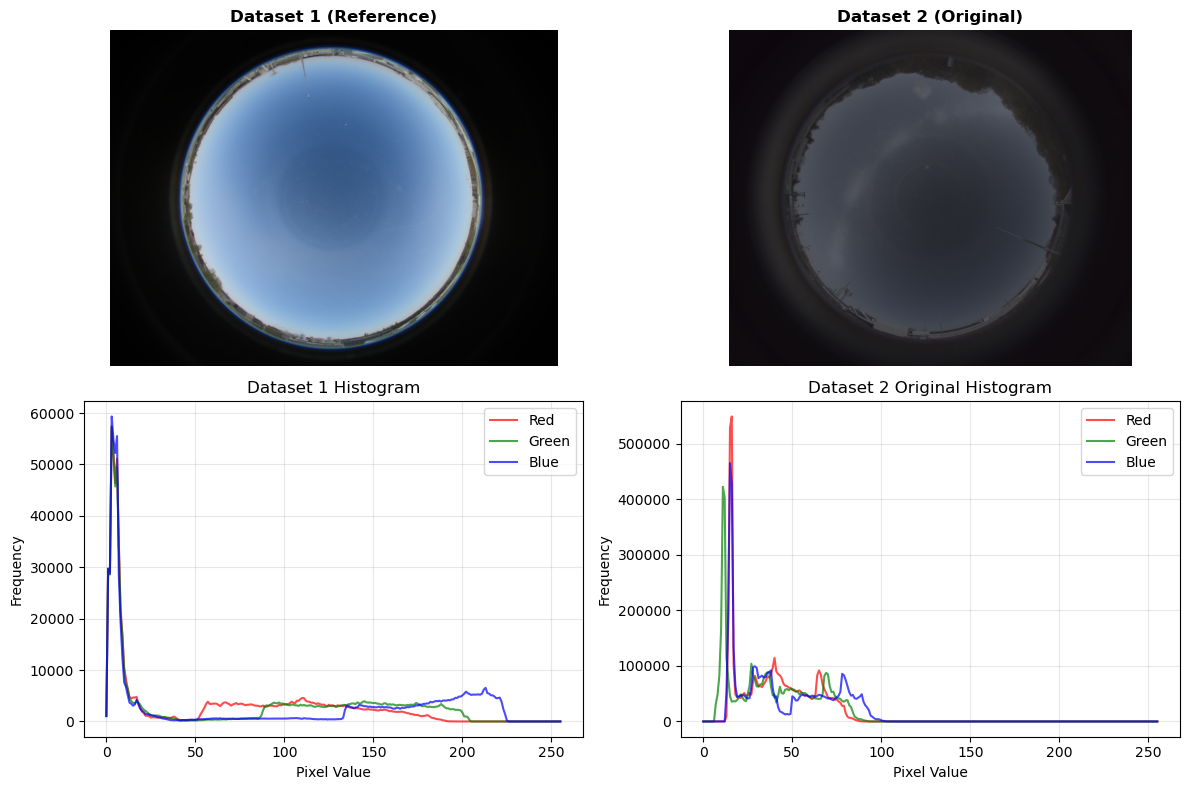

In [24]:
# Visualize the original color distributions before matching
if reference_image_dataset1 is not None and reference_image_dataset2 is not None:
    print("Comparing original color distributions:")
    visualize_histograms(reference_image_dataset1, reference_image_dataset2)
else:
    print("Cannot visualize - reference images not available")

## 10c. Test Histogram Matching on Sample Images

In [25]:
# Test histogram matching on sample images
if reference_image_dataset1 is not None and reference_image_dataset2 is not None:
    print("Testing histogram matching transformation...")
    
    # Apply histogram matching
    matched_reference = match_histogram(reference_image_dataset2, reference_image_dataset1)
    
    print("✓ Histogram matching applied")
    print("\nVisualizing before and after matching:")
    visualize_histograms(reference_image_dataset1, reference_image_dataset2, matched_reference)
else:
    print("Cannot test histogram matching - reference images not available")

Testing histogram matching transformation...
✓ Histogram matching applied

Visualizing before and after matching:


Testing histogram matching transformation...
✓ Histogram matching applied

Visualizing before and after matching:


## 11. Dataset Statistics and Summary

In [26]:
# Generate summary statistics
print("="*70)
print("DATASET PROCESSING SUMMARY")
print("="*70)

print(f"\n📁 Dataset 1 (gQg5IUvV):")
print(f"   Path: {DATASET1_PATH}")
print(f"   Filter: Images ending in '_01.jpg'")
print(f"   Total images found: {len(dataset1_images)}")

print(f"\n📁 Dataset 2 (OdnkTZQ8):")
print(f"   Path: {DATASET2_PATH}")
print(f"   Filter: Images with even minute timestamps")
print(f"   Total images found: {len(dataset2_images)}")

print(f"\n🔗 Matching Analysis:")
print(f"   Common timestamps: {len(common_timestamps)}")
print(f"   Loaded pairs: {len(sample_pairs)}")

if dataset1_index:
    print(f"\n⏰ Dataset 1 Time Range:")
    print(f"   Start: {min(dataset1_index.keys())}")
    print(f"   End:   {max(dataset1_index.keys())}")

if dataset2_index:
    print(f"\n⏰ Dataset 2 Time Range:")
    print(f"   Start: {min(dataset2_index.keys())}")
    print(f"   End:   {max(dataset2_index.keys())}")

print("\n" + "="*70)

DATASET PROCESSING SUMMARY

📁 Dataset 1 (gQg5IUvV):
   Path: /data/common/STEREOSTUDYIPSL/Datasets/gQg5IUvV/srf02_0a_skyimgLz2_v01_20250406_044600_853/20250406
   Filter: Images ending in '_01.jpg'
   Total images found: 427

📁 Dataset 2 (OdnkTZQ8):
   Path: /data/common/STEREOSTUDYIPSL/Datasets/OdnkTZQ8/RAW/RAW
   Filter: Images with even minute timestamps
   Total images found: 721

🔗 Matching Analysis:
   Common timestamps: 361
   Loaded pairs: 10

⏰ Dataset 1 Time Range:
   Start: 2025-04-06 04:46:00
   End:   2025-04-06 18:58:00

⏰ Dataset 2 Time Range:
   Start: 2025-04-06 05:00:00
   End:   2025-04-06 17:00:00



## 12. Additional Analysis Functions

## 11a. Circular Crop-Based Histogram Matching (Alternative Method)

This section implements an alternative histogram matching approach that focuses on the **circular center region** (radius = 40% of image height) for more accurate color matching.

In [40]:
# Circular Crop-Based Histogram Matching Functions

def create_circular_mask(height: int, width: int, radius_ratio: float = 0.4) -> np.ndarray:
    """
    Create a circular mask for the center of an image.
    
    Args:
        height: Image height
        width: Image width
        radius_ratio: Radius as a ratio of image height (default 0.4 = 40%)
        
    Returns:
        Boolean mask with True for pixels inside the circle
    """
    center_y, center_x = height // 2, width // 2
    radius = int(height * radius_ratio)
    
    Y, X = np.ogrid[:height, :width]
    dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    
    mask = dist_from_center <= radius
    return mask


def extract_circular_region(image: np.ndarray, radius_ratio: float = 0.4) -> np.ndarray:
    """
    Extract circular region from the center of an image.
    
    Args:
        image: Input image (H, W, C)
        radius_ratio: Radius as a ratio of image height (default 0.4 = 40%)
        
    Returns:
        Pixels from the circular region only (N, C)
    """
    height, width = image.shape[:2]
    mask = create_circular_mask(height, width, radius_ratio)
    
    # Extract pixels within the circle for each channel
    if len(image.shape) == 3:
        circular_pixels = image[mask]
    else:
        circular_pixels = image[mask]
    
    return circular_pixels


def compute_color_histogram_circular(image_paths: List[str], num_samples: int = 50, radius_ratio: float = 0.4) -> Tuple:
    """
    Compute color histogram from circular center regions of sample images.
    
    Args:
        image_paths: List of image file paths
        num_samples: Number of images to sample for histogram computation
        radius_ratio: Radius of circular crop as ratio of height (default 0.4 = 40%)
        
    Returns:
        Tuple of (reference_patch, all_circular_pixels, sample_full_image)
    """
    samples = min(num_samples, len(image_paths))
    sampled_paths = np.random.choice(image_paths, samples, replace=False)
    
    all_circular_regions = []
    sample_full_img = None
    
    print(f"Computing color histogram from circular center regions (r={radius_ratio*100:.0f}% of height)...")
    print(f"Sampling {samples} images...")
    
    for idx, path in enumerate(tqdm(sampled_paths, desc="Loading samples")):
        try:
            img = Image.open(path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_array = np.array(img)
            
            # Save first image for visualization
            if idx == 0:
                sample_full_img = img_array.copy()
            
            # Extract circular region
            circular_region = extract_circular_region(img_array, radius_ratio)
            all_circular_regions.append(circular_region)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            continue
    
    if not all_circular_regions:
        return None, None, None
    
    # Concatenate all circular regions
    all_pixels = np.concatenate(all_circular_regions, axis=0)
    
    print(f"✓ Extracted {len(all_pixels):,} pixels from circular regions")
    
    # Create a small reference patch for visualization
    mean_color = np.mean(all_pixels, axis=0).astype(np.uint8)
    reference_patch = np.tile(mean_color, (100, 100, 1)).astype(np.uint8)
    
    return reference_patch, all_pixels, sample_full_img


def match_histogram_circular(source_image: np.ndarray, reference_pixels: np.ndarray, radius_ratio: float = 0.4) -> np.ndarray:
    """
    Match histogram based on circular center regions.
    
    Args:
        source_image: Image to transform (RGB)
        reference_pixels: Reference pixels from circular regions (N, 3)
        radius_ratio: Radius ratio for circular mask
        
    Returns:
        Histogram-matched full image
    """
    # Create temporary image from reference pixels for matching
    n_ref = len(reference_pixels)
    ref_h = int(np.sqrt(n_ref)) + 1
    ref_img = np.zeros((ref_h, ref_h, 3), dtype=np.uint8)
    ref_img.flat[:n_ref*3] = reference_pixels.flatten()[:ref_h*ref_h*3]
    
    # Apply histogram matching on the full source image
    matched = exposure.match_histograms(source_image, ref_img, channel_axis=2)
    return matched.astype(np.uint8)


def visualize_histograms_circular(img1: np.ndarray, img2: np.ndarray, img2_matched: np.ndarray = None, radius_ratio: float = 0.3):
    """
    Visualize color histograms with circular region highlighting.
    
    Args:
        img1: Dataset 1 image (reference)
        img2: Dataset 2 original image
        img2_matched: Dataset 2 image after histogram matching (optional)
        radius_ratio: Radius ratio for circular crop visualization
    """
    colors = ['red', 'green', 'blue']
    labels = ['Red', 'Green', 'Blue']
    
    num_plots = 3 if img2_matched is not None else 2
    fig, axes = plt.subplots(2, num_plots, figsize=(6*num_plots, 8))
    
    # Show images with circular region highlighted
    for idx, (img, title) in enumerate([(img1, 'Dataset 1 (Reference)'), 
                                         (img2, 'Dataset 2 (Original)'),
                                         (img2_matched, 'Dataset 2 (Matched)') if img2_matched is not None else (None, None)]):
        if img is None:
            continue
        
        # Create circular mask specific to this image's dimensions
        h, w = img.shape[:2]
        mask = create_circular_mask(h, w, radius_ratio)
        
        # Create overlay showing circular region
        img_display = img.copy()
        overlay = img_display.copy()
        overlay[~mask] = (overlay[~mask] * 0.3).astype(np.uint8)  # Darken outside circle
        
        axes[0, idx].imshow(overlay)
        axes[0, idx].set_title(f'{title}\n(Circular region: r={radius_ratio*100:.0f}% of height)', 
                              fontweight='bold', fontsize=10)
        axes[0, idx].axis('off')
        
        # Add circle outline
        circle = plt.Circle((w//2, h//2), h*radius_ratio, color='yellow', fill=False, linewidth=2, linestyle='--')
        axes[0, idx].add_patch(circle)
    
    # Extract circular regions for histogram plotting
    circ1 = extract_circular_region(img1, radius_ratio)
    circ2 = extract_circular_region(img2, radius_ratio)
    if img2_matched is not None:
        circ2_matched = extract_circular_region(img2_matched, radius_ratio)
    
    # Plot histograms from circular regions only
    for i, (color, label) in enumerate(zip(colors, labels)):
        # Dataset 1 histogram (circular region)
        hist1, bins1 = np.histogram(circ1[:, i], bins=256, range=(0, 256))
        axes[1, 0].plot(bins1[:-1], hist1, color=color, alpha=0.7, label=label)
        
        # Dataset 2 original histogram (circular region)
        hist2, bins2 = np.histogram(circ2[:, i], bins=256, range=(0, 256))
        axes[1, 1].plot(bins2[:-1], hist2, color=color, alpha=0.7, label=label)
        
        # Dataset 2 matched histogram (circular region)
        if img2_matched is not None:
            hist3, bins3 = np.histogram(circ2_matched[:, i], bins=256, range=(0, 256))
            axes[1, 2].plot(bins3[:-1], hist3, color=color, alpha=0.7, label=label)
    
    axes[1, 0].set_title('Dataset 1 Histogram (Center Circle)')
    axes[1, 0].set_xlabel('Pixel Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    axes[1, 1].set_title('Dataset 2 Original Histogram (Center Circle)')
    axes[1, 1].set_xlabel('Pixel Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    if img2_matched is not None:
        axes[1, 2].set_title('Dataset 2 Matched Histogram (Center Circle)')
        axes[1, 2].set_xlabel('Pixel Value')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].legend()
        axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Circular crop-based histogram matching functions defined")

✓ Circular crop-based histogram matching functions defined


## 11b. Compute Circular-Based Reference Histograms

In [44]:
# Compute circular-based reference histograms from both datasets
print("Computing reference color distributions from circular center regions...\n")

# Set random seed for reproducibility
np.random.seed(42)

# Compute reference from Dataset 1 (circular regions)
print("Dataset 1 (Reference):")
ref_patch1, ref_pixels1, sample_img1 = compute_color_histogram_circular(
    dataset1_images, num_samples=50, radius_ratio=0.4
)

print("\nDataset 2 (To be matched):")
ref_patch2, ref_pixels2, sample_img2 = compute_color_histogram_circular(
    dataset2_images, num_samples=50, radius_ratio=0.3
)

if ref_pixels1 is not None and ref_pixels2 is not None:
    print("\n✓ Circular-based reference histograms computed successfully")
    print(f"Dataset 1 circular pixels: {len(ref_pixels1):,} pixels")
    print(f"Dataset 2 circular pixels: {len(ref_pixels2):,} pixels")
else:
    print("\n✗ Failed to compute circular-based reference histograms")

Computing reference color distributions from circular center regions...

Dataset 1 (Reference):
Computing color histogram from circular center regions (r=40% of height)...
Sampling 50 images...


Loading samples: 100%|██████████| 50/50 [00:01<00:00, 48.71it/s]



✓ Extracted 14,801,250 pixels from circular regions

Dataset 2 (To be matched):
Computing color histogram from circular center regions (r=30% of height)...
Sampling 50 images...

Dataset 2 (To be matched):
Computing color histogram from circular center regions (r=30% of height)...
Sampling 50 images...


Loading samples: 100%|██████████| 50/50 [00:05<00:00,  8.66it/s]



✓ Extracted 59,600,650 pixels from circular regions

✓ Circular-based reference histograms computed successfully
Dataset 1 circular pixels: 14,801,250 pixels
Dataset 2 circular pixels: 59,600,650 pixels

✓ Circular-based reference histograms computed successfully
Dataset 1 circular pixels: 14,801,250 pixels
Dataset 2 circular pixels: 59,600,650 pixels


## 11c. Visualize Circular Regions and Original Distributions

In [45]:
# Visualize the circular regions and color distributions
if sample_img1 is not None and sample_img2 is not None:
    print("Comparing color distributions from circular center regions:")
    visualize_histograms_circular(sample_img1, sample_img2, radius_ratio=0.3)
else:
    print("Cannot visualize - sample images not available")

Comparing color distributions from circular center regions:


## 11d. Test Circular-Based Histogram Matching

Testing circular-based histogram matching transformation...


✓ Circular-based histogram matching applied

Visualizing before and after matching (circular regions highlighted):


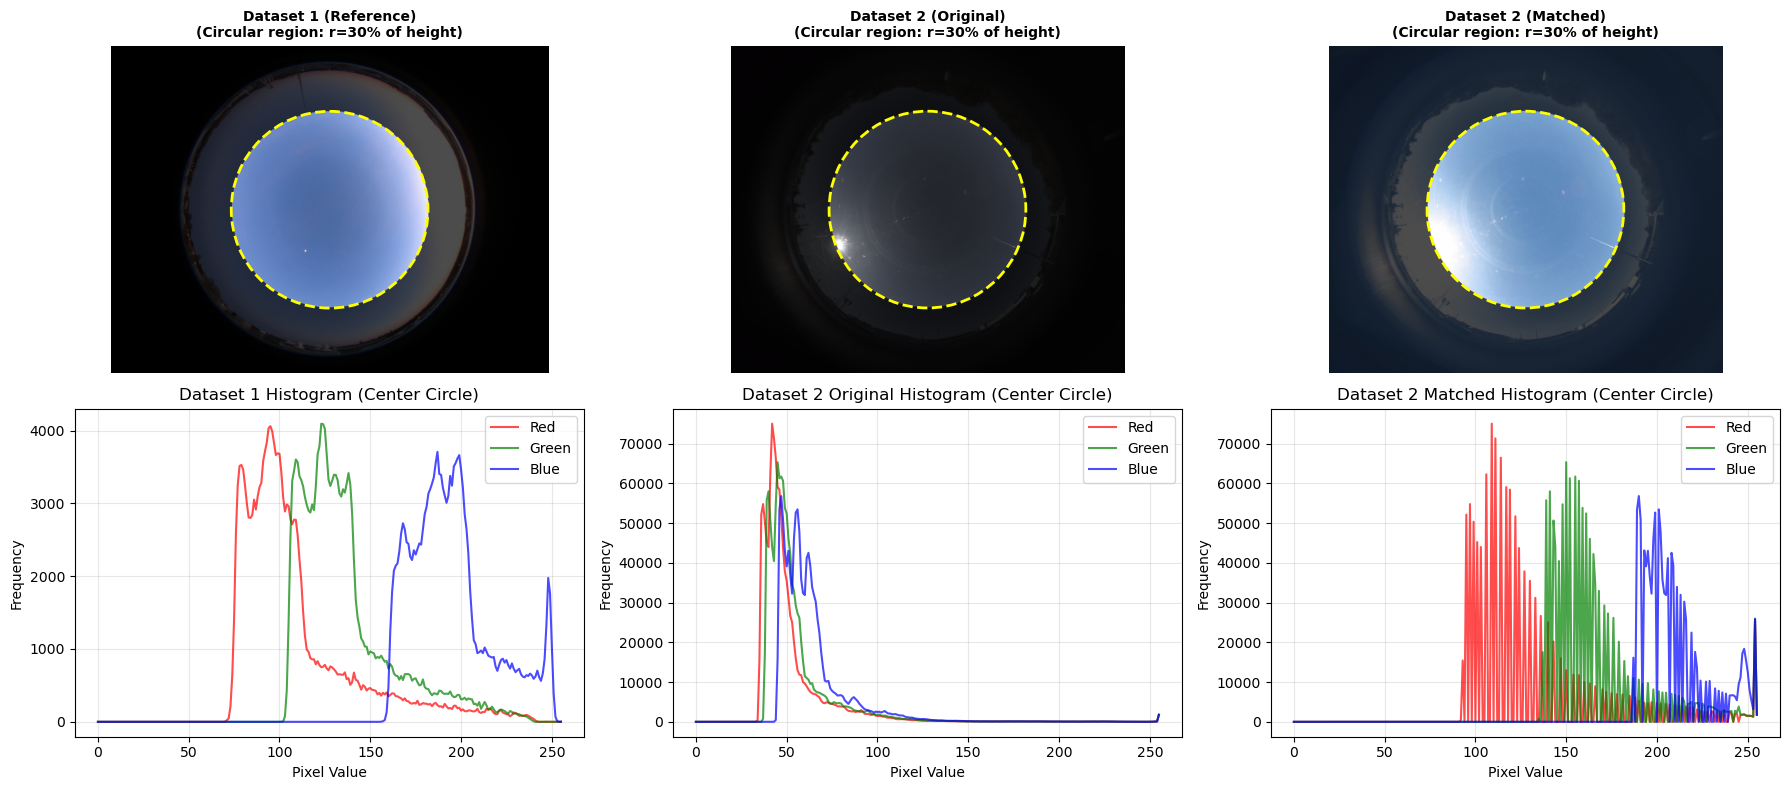

In [47]:
# Test circular-based histogram matching on sample images
if sample_img1 is not None and sample_img2 is not None and ref_pixels1 is not None:
    print("Testing circular-based histogram matching transformation...")
    
    # Apply histogram matching using circular regions
    matched_sample = match_histogram_circular(sample_img2, ref_pixels1, radius_ratio=0.4)
    
    print("✓ Circular-based histogram matching applied")
    print("\nVisualizing before and after matching (circular regions highlighted):")
    visualize_histograms_circular(sample_img1, sample_img2, matched_sample, radius_ratio=0.3)
else:
    print("Cannot test histogram matching - reference data not available")

## 11e. Compare Image Pairs with Circular-Based Matching

Loading sample pairs with circular-based histogram matching...


Loading and matching: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]




✓ Loaded 3 pairs with circular-based histogram matching

Visualizing pairs (Dataset 2 enhanced + circular-based histogram matched):


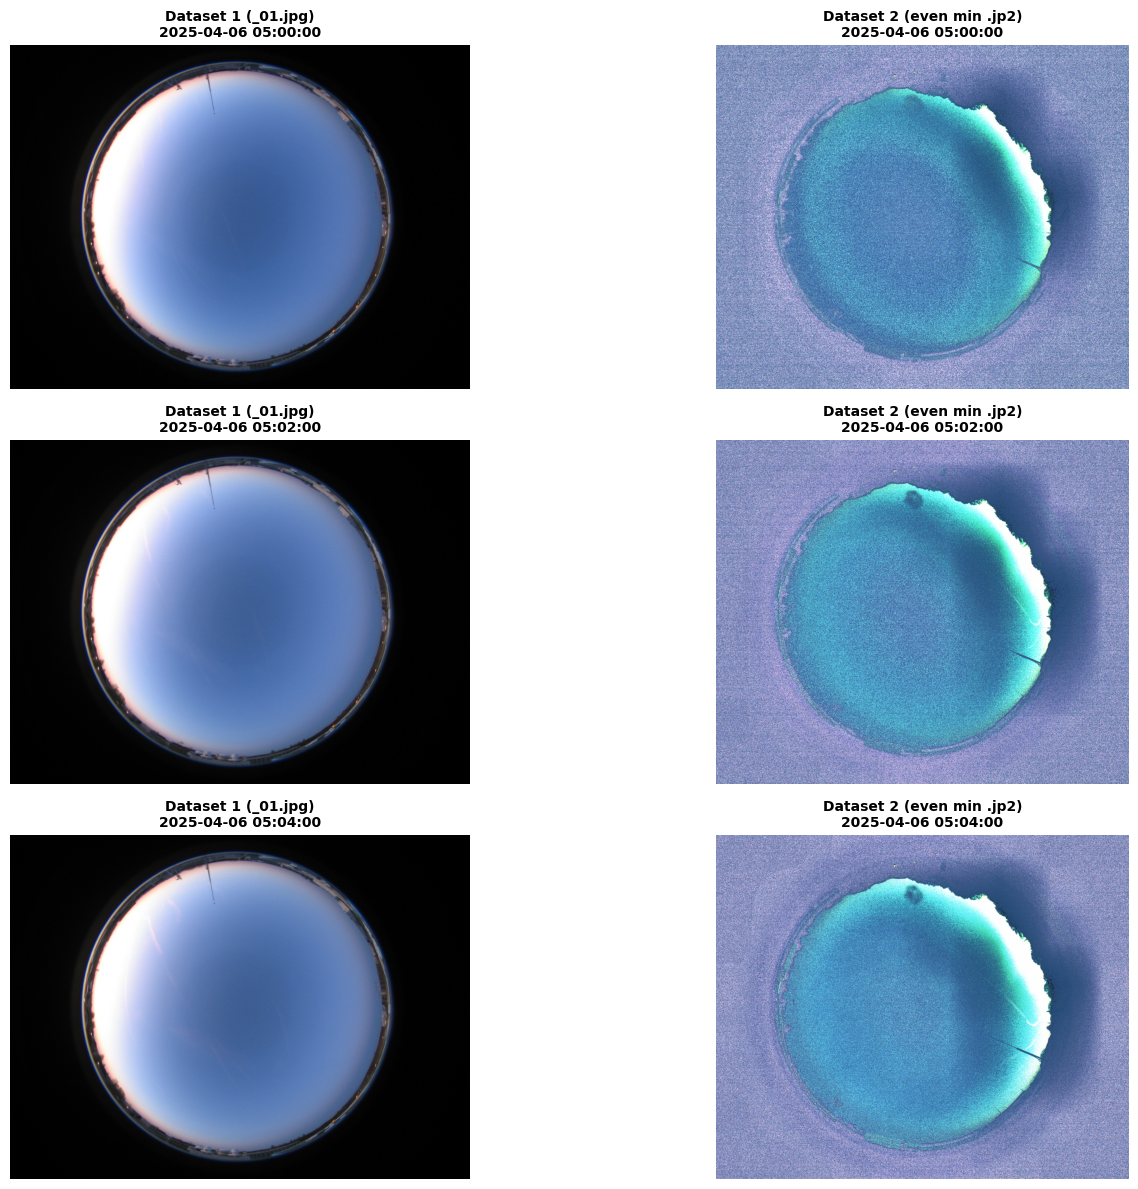

In [48]:
# Load image pairs with circular-based histogram matching
if len(common_timestamps) > 0 and ref_pixels1 is not None:
    print("Loading sample pairs with circular-based histogram matching...")
    
    NUM_COMPARISON_SAMPLES = min(3, len(common_timestamps))
    
    # Load pairs and apply circular-based matching
    pairs_circular_matching = []
    
    for ts in tqdm(common_timestamps[:NUM_COMPARISON_SAMPLES], desc="Loading and matching"):
        try:
            path1 = dataset1_index[ts]
            path2 = dataset2_index[ts]
            
            # Load images
            img1 = Image.open(path1)
            img2 = Image.open(path2)
            
            if img1.mode != 'RGB':
                img1 = img1.convert('RGB')
            if img2.mode != 'RGB':
                img2 = img2.convert('RGB')
            
            # Apply enhancement to Dataset 2
            img2_array = np.array(img2)
            img2_bgr = cv2.cvtColor(img2_array, cv2.COLOR_RGB2BGR)
            enhanced_img2 = enhance_image(img2_bgr)
            enhanced_img2_rgb = cv2.cvtColor(enhanced_img2, cv2.COLOR_BGR2RGB)
            
            # Apply circular-based histogram matching
            matched_img2 = match_histogram_circular(enhanced_img2_rgb, ref_pixels1, radius_ratio=0.4)
            img2_final = Image.fromarray(matched_img2)
            
            pairs_circular_matching.append((ts, img1, img2_final, path1, path2))
        except Exception as e:
            print(f"Error processing {ts}: {e}")
    
    # Visualize
    if pairs_circular_matching:
        print(f"\n✓ Loaded {len(pairs_circular_matching)} pairs with circular-based histogram matching")
        print("\nVisualizing pairs (Dataset 2 enhanced + circular-based histogram matched):")
        visualize_image_pairs(pairs_circular_matching, num_rows=len(pairs_circular_matching))
    else:
        print("No pairs loaded")
else:
    print("Skipping - not enough data or circular reference histograms not computed")

In [34]:
# Optional: Load and visualize more pairs
def load_and_visualize_custom_range(start_idx: int = 0, end_idx: int = 10):
    """
    Load and visualize a custom range of image pairs.
    
    Args:
        start_idx: Starting index in common_timestamps
        end_idx: Ending index in common_timestamps
    """
    if not common_timestamps:
        print("No common timestamps available")
        return
    
    end_idx = min(end_idx, len(common_timestamps))
    timestamps_range = common_timestamps[start_idx:end_idx]
    
    # Check if we should apply histogram matching
    apply_matching = 'reference_image_dataset1' in globals() and reference_image_dataset1 is not None
    reference = reference_image_dataset1 if apply_matching else None
    
    print(f"Loading images from index {start_idx} to {end_idx}...")
    pairs = load_image_pairs_parallel(
        timestamps_range, dataset1_index, dataset2_index,
        apply_histogram_matching=apply_matching,
        reference_img=reference
    )
    
    if pairs:
        print(f"Visualizing {len(pairs)} pairs...")
        visualize_image_pairs(pairs, num_rows=len(pairs))
    else:
        print("No pairs loaded")

print("✓ Custom visualization function ready")
print("\nTo visualize a different range, call:")
print("  load_and_visualize_custom_range(start_idx=10, end_idx=15)")

✓ Custom visualization function ready

To visualize a different range, call:
  load_and_visualize_custom_range(start_idx=10, end_idx=15)


## 13. Export Functionality (Optional)

In [35]:
def save_paired_images(pairs: List[Tuple], output_dir: str = "./processed_pairs"):
    """
    Save paired images to an output directory.
    
    Args:
        pairs: List of image pairs
        output_dir: Directory to save paired images
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for timestamp, img1, img2, _, _ in tqdm(pairs, desc="Saving pairs"):
        timestamp_str = timestamp.strftime("%Y%m%d_%H%M%S")
        
        # Create side-by-side image
        width1, height1 = img1.size
        width2, height2 = img2.size
        
        # Resize to same height
        max_height = max(height1, height2)
        img1_resized = img1.resize((int(width1 * max_height / height1), max_height))
        img2_resized = img2.resize((int(width2 * max_height / height2), max_height))
        
        # Create combined image
        total_width = img1_resized.width + img2_resized.width
        combined = Image.new('RGB', (total_width, max_height))
        combined.paste(img1_resized, (0, 0))
        combined.paste(img2_resized, (img1_resized.width, 0))
        
        # Save
        output_path = os.path.join(output_dir, f"pair_{timestamp_str}.jpg")
        combined.save(output_path, quality=95)
    
    print(f"\n✓ Saved {len(pairs)} paired images to {output_dir}")

print("✓ Export function ready")
print("\nTo save paired images, call:")
print("  save_paired_images(sample_pairs, output_dir='./processed_pairs')")

✓ Export function ready

To save paired images, call:
  save_paired_images(sample_pairs, output_dir='./processed_pairs')
